In [137]:
%load_ext autoreload
%autoreload 2

 
import sys
sys.path.append("..")
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing the LLM models and the necessary modules

In [138]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

openai_api_key = "#"

openai_llm_model = ChatOpenAI(
    api_key = openai_api_key,
    model="o3-mini",
    #temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

openai_embeddings_model = OpenAIEmbeddings(
    api_key = openai_api_key ,
    model="text-embedding-3-large",
)


In [139]:
from atom.utils import LangchainOutputParser

lg = LangchainOutputParser(llm_model=openai_llm_model, embeddings_model=openai_embeddings_model)

# Loading the datasets

In [170]:
import pandas as pd
import ast

def recover_list_dfs(df):
    for col in df.columns:
        if df[col].dtype == object:  # Ensure we only process object (string) columns
            first_valid_index = df[col].first_valid_index()
            if first_valid_index is not None and isinstance(df[col].loc[first_valid_index], str):
                first_value = df[col].loc[first_valid_index].strip()  # Strip any whitespace
                if first_value.startswith("[") and first_value.endswith("]"):  # Ensure it's a list format
                    def safe_eval(x):
                        try:
                            return ast.literal_eval(x) if isinstance(x, str) else x
                        except (SyntaxError, ValueError) as e:
                            print(f"Skipping invalid value in column '{col}': {x} -> {e}")
                            return None  # Return None for problematic values
                    df[col] = df[col].apply(safe_eval)
                    
    return df
    

df_news = recover_list_dfs(pd.read_excel("../datasets/news/df_news_all_llms_eval.xlsx"))
df_abstracts = recover_list_dfs(pd.read_excel("../datasets/abstracts/df_abstracts_all_llms_eval.xlsx"))

# Extracting triplets and factoids

In [4]:
from atom.utils import Factoid
from atom.utils import RelationshipsExtractor
from datetime import datetime
async def extract_factoids(batch):

    factoids = await lg.extract_information_as_json_for_context(output_data_structure=Factoid, contexts=batch)

    return [factoid.phrase for factoid in factoids]

async def extract_triplets(batch):
    observation_time = str(datetime.now().date())
    IE_query = f""" 
    Observation Time : {observation_time}
    You are a top-tier algorithm designed for extracting information in structured 
    formats to build a knowledge graph.
    Try to capture as much information from the text as possible without 
    sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text
    Remember, the knowledge graph should be coherent and easily understandable, 
    so maintaining consistency in entity references is crucial.
    """
    examples = """ 
    FEW SHOT EXAMPLES \n
    * Michel served as CFO at Acme Corp from 2019 to 2021. He was hired by Beta Inc in 2021, but left that role in 2023. -> (michel, is_cfo, acme corp, [2019], [2021]), (michel, was_hired_by, beta inc, 2021, 2023)
    \n
    * Subsequent experiments confirmed the role of microRNAs in modulating cell growth. -> (experiments, confirmed_role, micrornas, [], []), (micrornas, modulate, cell growth, [], [])
    \n
    * Researchers used high-resolution imaging in a study on neural plasticity. -> (researchers, used, high-resolution imaging, [], []), (high-resolution imaging, used_in, study on neural plasticity, [], [])
    \n
    * Sarah was a board member of GreenFuture until 2019. -> (Sarah, is_board_member, greenfuture, [], [2019])
    \n
    * Dr. Lee was the head of the Oncology Department until 2022. -> (dr. lee, is_head_of, oncology department, [], [2022])
    \n
    * Activity-dependent modulation of receptor trafficking is crucial for maintaining synaptic efficacy. -> (activity-dependent modulation, involves, receptor trafficking, [], []), (receptor trafficking, maintains, synaptic efficacy, [], [])
    \n
    * (observation time = <observation_date>) John Doe is no longer the CEO of GreenIT a few months ago. -> (john doe, is_CEO, greenit, [], [<new observation_date by deducting 3months >])
    """

    relations = await lg.extract_information_as_json_for_context(output_data_structure=RelationshipsExtractor, contexts=batch, system_query=IE_query+examples)

    relations = [relation.relationships for relation in relations]

    return list(map(lambda rel : [(relation.startNode.name, relation.name, relation.endNode.name, relation.t_valid, relation.t_invalid) for relation in rel], relations))


In [10]:
import asyncio
import ast

async def extract_all_triplets(df, trip_col_name, fact_col_name):
    if isinstance(df[fact_col_name].iloc[0], str):
        df[fact_col_name] = df[fact_col_name].apply(lambda x: ast.literal_eval(x))
    df[trip_col_name] = await asyncio.gather(
        *[extract_triplets(factoid) for factoid in df[fact_col_name]]
    )
    return df


# Stability regarding multiple runs
---

In [142]:
df_abstracts["triplets_run_o3mini"] = await extract_triplets(batch=df_abstracts["paragraph"])

Total number of batches: 1


In [143]:
df_news["triplets_run_o3mini"] = await extract_triplets(batch=df_news["paragraph"])

Total number of batches: 1


In [144]:
df_abstracts = await extract_all_triplets(df_abstracts, trip_col_name="triplets_factoids_run_o3mini", fact_col_name="factoids_ground_truth")

Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
T

In [145]:
df_news = await extract_all_triplets(df_news, trip_col_name="triplets_factoids_run_o3mini", fact_col_name="factoids_ground_truth")

Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
Total number of batches: 1
T

In [360]:
from sklearn.metrics.pairwise import cosine_similarity


async def measure_stability(reference_set, compared_set):
    def clean_triplets(triplet):
        return (triplet[0].lower().replace("_", " "), 
                triplet[1].lower(), 
                triplet[2].lower().replace("_", " "),
                triplet[3],
                triplet[4]
                    )
    reference_set = list(map(clean_triplets, reference_set))
    compared_set = list(map(clean_triplets, compared_set))


    v_reference_set = await lg.calculate_embeddings(text=list(map(lambda x: f"{x[0]} {x[1]} {x[2]}", reference_set)))
    v_compared_set = await lg.calculate_embeddings(text=list(map(lambda x: f"{x[0]} {x[1]} {x[2]}", compared_set)))

    centroid1 = v_reference_set.mean(axis=0)
    centroid2 = v_compared_set.mean(axis=0)

    # Reshape centroids to 2D arrays and compute similarity
    return cosine_similarity(centroid1.reshape(1, -1), centroid2.reshape(1, -1))[0][0]


async def compute_stabilities(df_news):
    # For triplets: reference set is "triplets_run_1", compared sets are run2, run3, and run4
    stability_triplets_run12 = await asyncio.gather(*[
        measure_stability(row["triplets_run_1"], row["triplets_run_2"])
        for _, row in df_news.iterrows()
    ])
    stability_triplets_run13 = await asyncio.gather(*[
        measure_stability(row["triplets_run_1"], row["triplets_run_3"])
        for _, row in df_news.iterrows()
    ])
    stability_triplets_run14 = await asyncio.gather(*[
        measure_stability(row["triplets_run_1"], row["triplets_run_4"])
        for _, row in df_news.iterrows()
    ])

    df_news["stability_triplets_run12"] = stability_triplets_run12
    df_news["stability_triplets_run13"] = stability_triplets_run13
    df_news["stability_triplets_run14"] = stability_triplets_run14

    # For factoids: assume each cell in the factoids columns is a list of lists;
    # flatten the lists using chain, then compare against the reference run _1
    stability_factoids_run12 = await asyncio.gather(*[
        measure_stability(list(chain(*row["triplets_factoids_run_1"])), list(chain(*row["triplets_factoids_run_2"])))
        for _, row in df_news.iterrows()
    ])
    stability_factoids_run13 = await asyncio.gather(*[
        measure_stability(list(chain(*row["triplets_factoids_run_1"])), list(chain(*row["triplets_factoids_run_3"])))
        for _, row in df_news.iterrows()
    ])
    stability_factoids_run14 = await asyncio.gather(*[
        measure_stability(list(chain(*row["triplets_factoids_run_1"])), list(chain(*row["triplets_factoids_run_4"])))
        for _, row in df_news.iterrows()
    ])

    df_news["stability_triplets_factoids_run12"] = stability_factoids_run12
    df_news["stability_triplets_factoids_run13"] = stability_factoids_run13
    df_news["stability_triplets_factoids_run14"] = stability_factoids_run14

# Run the async function to compute stabilities and update your DataFrame.
await compute_stabilities(df_news)

In [378]:
await compute_stabilities(df_abstracts)

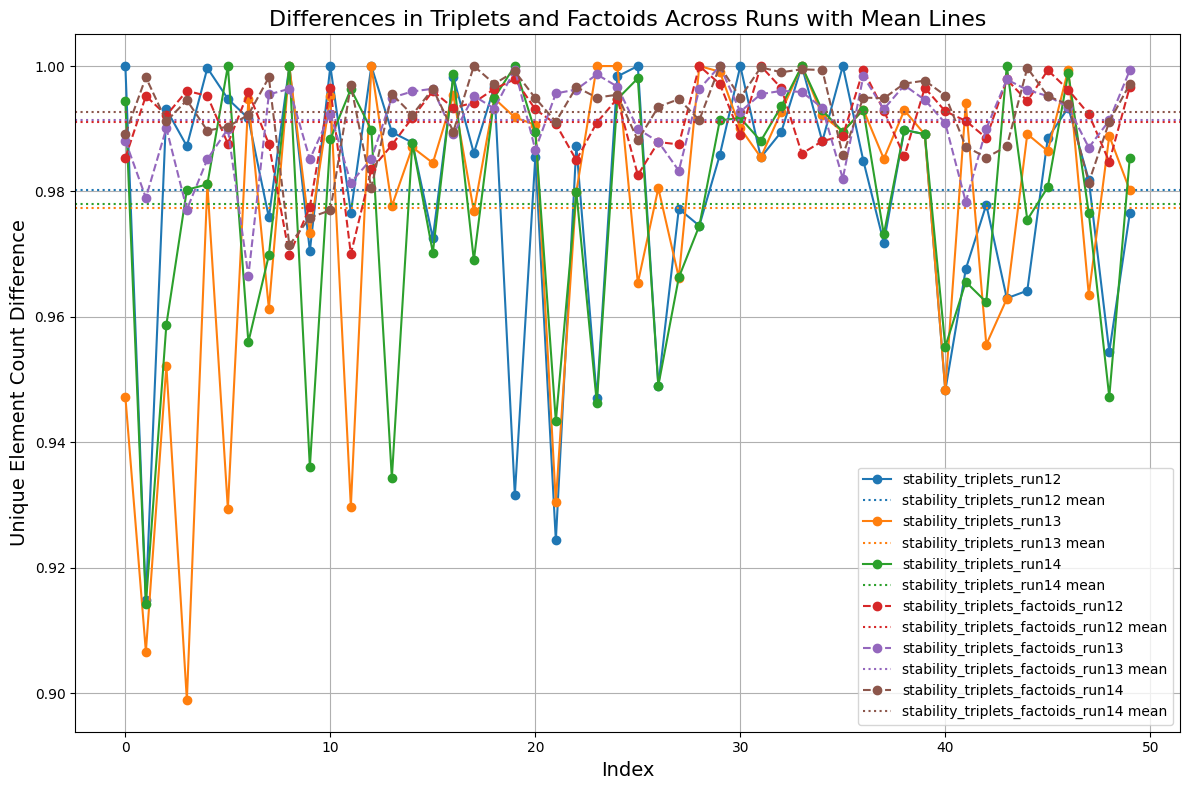

In [362]:
import matplotlib.pyplot as plt

# Define the columns to plot
cols = [
    "stability_triplets_run12",
    "stability_triplets_run13",
    "stability_triplets_run14",
    "stability_triplets_factoids_run12",
    "stability_triplets_factoids_run13",
    "stability_triplets_factoids_run14"
]

plt.figure(figsize=(12, 8))

for col in cols:
    # Set linestyle: dashed for factoids, solid otherwise
    linestyle = "--" if "_triplets_factoids" in col else "-"
    # Plot the curve and store the line handle to extract its color
    line, = plt.plot(df_news.index, df_news[col], marker='o', linestyle=linestyle, label=col)
    # Compute the mean of the current column
    mean_val = df_news[col].mean()
    # Plot a horizontal line for the mean using the same color but a dotted linestyle
    plt.axhline(mean_val, color=line.get_color(), linestyle=':', 
                label=f'{col} mean')

plt.title("Differences in Triplets and Factoids Across Runs with Mean Lines", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Unique Element Count Difference", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

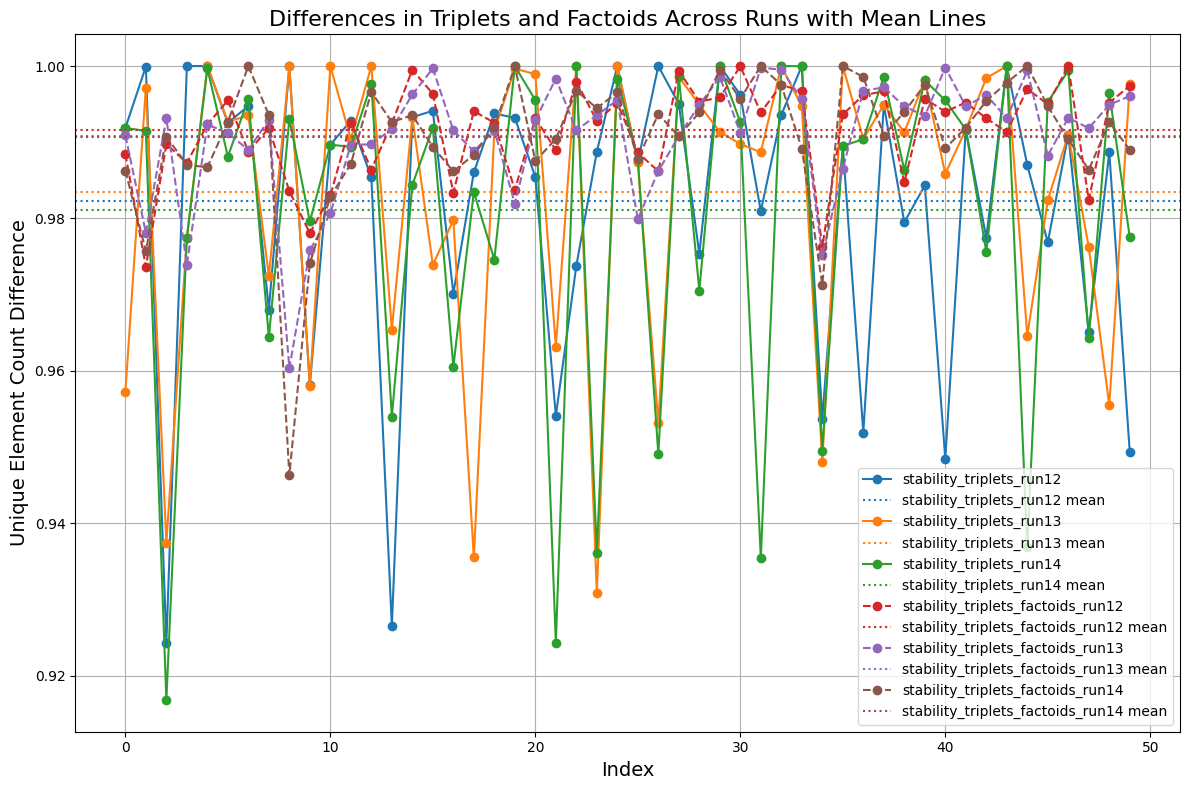

In [379]:
import matplotlib.pyplot as plt

# Define the columns to plot
cols = [
    "stability_triplets_run12",
    "stability_triplets_run13",
    "stability_triplets_run14",
    "stability_triplets_factoids_run12",
    "stability_triplets_factoids_run13",
    "stability_triplets_factoids_run14"
]

plt.figure(figsize=(12, 8))

for col in cols:
    # Set linestyle: dashed for factoids, solid otherwise
    linestyle = "--" if "_triplets_factoids" in col else "-"
    # Plot the curve and store the line handle to extract its color
    line, = plt.plot(df_abstracts.index, df_abstracts[col], marker='o', linestyle=linestyle, label=col)
    # Compute the mean of the current column
    mean_val = df_abstracts[col].mean()
    # Plot a horizontal line for the mean using the same color but a dotted linestyle
    plt.axhline(mean_val, color=line.get_color(), linestyle=':', 
                label=f'{col} mean')

plt.title("Differences in Triplets and Factoids Across Runs with Mean Lines", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Unique Element Count Difference", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [402]:
for i in range(2,5):
    print("---news---")
    print("-factoids-")
    print(df_news[f"stability_triplets_factoids_run1{i}"].mean(), df_news[f"stability_triplets_factoids_run1{i}"].std())
    print("-without-")
    print(df_news[f"stability_triplets_run1{i}"].mean(), df_news[f"stability_triplets_run1{i}"].std())
    print("---abstracts---")
    print("-factoids-")
    print(df_abstracts[f"stability_triplets_factoids_run1{i}"].mean(), df_abstracts[f"stability_triplets_factoids_run1{i}"].std())
    print("-without-")
    print(df_abstracts[f"stability_triplets_run1{i}"].mean(), df_abstracts[f"stability_triplets_run1{i}"].std())

---news---
-factoids-
0.9911194013614656 0.006726027995617663
-without-
0.9801963319058435 0.020429760504944813
---abstracts---
-factoids-
0.9915736932878546 0.00621692216084702
-without-
0.9822842620344784 0.01892404564306338
---news---
-factoids-
0.9913135412682093 0.006855952473133361
-without-
0.9773706860442172 0.024640303431676832
---abstracts---
-factoids-
0.9907821888709336 0.007860651562996136
-without-
0.9834563721504113 0.01921189087012853
---news---
-factoids-
0.9926515771564474 0.006576216514192377
-without-
0.9780227980183696 0.02064141018039058
---abstracts---
-factoids-
0.9907040850145715 0.009043847300304844
-without-
0.9811442297875006 0.02209471724685887


# Changing the LLM
---

In [ ]:
from langchain_mistralai import ChatMistralAI
from langchain_mistralai import MistralAIEmbeddings

mistral_api_key = "#"
mistral_llm_model = ChatMistralAI(
    api_key = mistral_api_key,
    model="mistral-large-latest",
    temperature=0,
    max_retries=2,
)


mistral_embeddings_model = MistralAIEmbeddings(
    model="mistral-embed",
    api_key = mistral_api_key
)

In [18]:
from atom.utils import LangchainOutputParser

lg = LangchainOutputParser(llm_model=mistral_llm_model, embeddings_model=openai_embeddings_model)

In [56]:
async def process_batches(df, batch_size=5):
    # Ensure the column exists
    if "triplets_run_mistral_ai" not in df.columns:
        df["triplets_run_mistral_ai"] = None

    # Find the first index where the column is None
    null_rows = df[df["triplets_run_mistral_ai"].isnull()]
    if null_rows.empty:
        # All rows already processed; nothing to do.
        return df
    start_index = null_rows.index[0]
    
    # Process in batches from the start_index onward
    for i in range(start_index, len(df), batch_size):
        batch = df["paragraph"].iloc[i:i+batch_size].tolist()  # Extract batch
        triplets_batch = await extract_triplets(batch)          # Async call
        
        # Update the DataFrame slice using .loc
        end_index = i + len(triplets_batch)
        df["triplets_run_mistral_ai"][i:end_index] = triplets_batch  

    return df

In [36]:
batch = df_abstracts["paragraph"].iloc[0:5].tolist()  # Extract batch
triplets_batch = await extract_triplets(batch)  # Async call

Total number of batches: 1


In [ ]:
df_news = await process_batches(df_news)

In [64]:
df_abstracts["factoids_ground_truth"]

0     [Researchers investigated cellular mechanisms ...
1     [Climate scientists developed a novel framewor...
2     [Geneticists used CRISPR-Cas9 technology to ed...
3     [Researchers conducted a comprehensive analysi...
4     [The investigation focused on the neurobiologi...
5     [Materials scientists synthesized a novel poly...
6     [Epidemiologists conducted a multi-center stud...
7     [International observatories collaborated to d...
8     [Researchers in computational linguistics deve...
9     [Researchers quantified trace levels of heavy ...
10    [Researchers developed a novel technique for p...
11    [On April 2, 2027, a collaborative study in ma...
12    [In early 2027, neuroscientists published a br...
13    [A recent study in environmental chemistry qua...
14    [Engineers designed a novel algorithm to adjus...
15    [Epidemiologists investigated the transmission...
16    [Biologists sequenced the complete genome of a...
17    [Drought stress induces a complex network 

In [91]:
from pydantic import ValidationError
import asyncio
from httpx import HTTPStatusError

async def process_factoids_row(factoids, existing_triplets=None, batch_size=5, max_retries=5):
    """
    Process a single row's factoids in batches, resuming where left off.
    If a Pydantic ValidationError occurs, retry the batch up to `max_retries` times.

    Parameters:
      factoids: list of phrases to process.
      existing_triplets: previously extracted triplets (or None).
      batch_size: number of phrases to process per batch.
      max_retries: maximum number of retries if a ValidationError occurs.

    Returns:
      A list containing all extracted triplets.
    """
    # Start with already computed triplets if available.
    if isinstance(factoids, str):
        factoids = ast.literal_eval(factoids)
    if existing_triplets is None:
        existing_triplets = []
    
    processed_count = len(existing_triplets)
    all_triplets = existing_triplets[:]  # Copy already processed triplets

    # Process the remaining factoids in batches.
    for i in range(processed_count, len(factoids), batch_size):
        batch = factoids[i:i + batch_size]
        retries = 0
        
        while retries < max_retries:
            try:
                triplets_batch = await extract_triplets(batch)  # Async call to extract triplets
                break  # Exit the retry loop if successful
            except ValidationError as e:
                retries += 1
                print(f"ValidationError encountered: {e}. Retrying {retries}/{max_retries} for batch starting at index {i}.")
                await asyncio.sleep(1)  # Wait 1 second before retrying
            except HTTPStatusError as he:
                retries += 1
                print(f"HTTPStatusError encountered for batch starting at index {i}: {he}. "
                      f"Retrying {retries}/{max_retries} after 60 seconds.")
                await asyncio.sleep(60)
        else:
            # If max_retries is reached without success, log and skip this batch
            print(f"Max retries exceeded for batch starting at index {i}. Skipping this batch.")
            triplets_batch = []  # Or consider raising an error if needed
        
        all_triplets.extend(triplets_batch)
    
    return all_triplets

async def process_all_factoids(df, batch_size=5):
    """
    Process each row's factoids from df['factoids_ground_truth'] in batches.
    Resumes processing if some triplets have already been computed.

    Parameters:
      df: DataFrame with a column "factoids_ground_truth" (list of phrases).
      batch_size: number of phrases to process per batch.

    Returns:
      The DataFrame updated with a new column "triplets_factoids_run_mistral_ai".
    """
    # Ensure the output column exists.
    if "triplets_factoids_run_mistral_ai" not in df.columns:
        df["triplets_factoids_run_mistral_ai"] = None

    # Process each row.
    for idx, row in df.iterrows():
        # Retrieve any existing triplets; if None, initialize to an empty list.
        existing_triplets = row["triplets_factoids_run_mistral_ai"] or []
        factoids = row["factoids_ground_truth"]
        # Process the row's factoids, resuming from where we left off.
        updated_triplets = await process_factoids_row(factoids, existing_triplets, batch_size=batch_size)
            
        # Update the DataFrame using .loc to avoid chained assignment issues.
        df["triplets_factoids_run_mistral_ai"][idx] = updated_triplets

    return df

In [93]:
df_news["triplets_factoids_run_mistral_ai"]

0     [[(Gathering, held_in, Copenhagen, ['2025-11-0...
1     [[(local election, held_in, Ohio, ['2025-10-15...
2     [[(Announcement, involves, plans to merge, [],...
3     [[(Mobilization, involves, mobilized, ['2025-0...
4     [[(NASA, made, Announcement, ['2025-02-28'], [...
5     [[(Debate, occurred_in, National Parliament, [...
6     [[(Unveiling, held_by, Global Institute of Tec...
7     [[(Convened, involves, Trade ministers, ['2025...
8     [[(Data Breach, occurred_on, 2025-06-16, [], [...
9     [[(Final Match, is_part_of, Championship Tourn...
10    [[(Annual Cultural Festival, took_place_in, Sa...
11    [[(Breakthrough study, was_revealed_by, Univer...
12    [[(Global Oil Prices Surge, occurred_on, 2025-...
13    [[(Inauguration, inaugurated, Renewable Energy...
14    [[(Stock Market Crash, occurred_on, 2025-12-03...
15    [[(Drought, devastated, Central Plains, ['2025...
16    [[(Scandal, involves, Metropolitan Area, ['202...
17    [[(landmark art exhibition, opened_at, Mod

In [ ]:
df_news = await process_all_factoids(df_news)

In [161]:
async def compute_stabilities(df_news):
    # For triplets: reference set is "triplets_run_1", compared sets are run2, run3, and run4
    stability_triplets_run12 = await asyncio.gather(*[
        measure_stability(row["triplets_run_gpt4o"], row["triplets_run_mistral_ai"])
        for _, row in df_news.iterrows()
    ])
    stability_triplets_run13 = await asyncio.gather(*[
        measure_stability(row["triplets_run_gpt4o"], row["triplets_run_o3mini"])
        for _, row in df_news.iterrows()
    ])


    df_news["stability_triplets_run_gpt4o_mistral"] = stability_triplets_run12
    df_news["stability_triplets_run_gpt4o_o3mini"] = stability_triplets_run13

    # For factoids: assume each cell in the factoids columns is a list of lists;
    # flatten the lists using chain, then compare against the reference run _1
    stability_factoids_run12 = await asyncio.gather(*[
        measure_stability(list(chain(*row["triplets_factoids_run_gpt4o"])), list(chain(*row["triplets_factoids_run_mistral_ai"])))
        for _, row in df_news.iterrows()
    ])
    stability_factoids_run13 = await asyncio.gather(*[
        measure_stability(list(chain(*row["triplets_factoids_run_gpt4o"])), list(chain(*row["triplets_factoids_run_o3mini"])))
        for _, row in df_news.iterrows()
    ])
  

    df_news["stability_triplets_factoids_run_gpt4o_mistral"] = stability_factoids_run12
    df_news["stability_triplets_factoids_run_gpt4o_o3mini"] = stability_factoids_run13

# Run the async function to compute stabilities and update your DataFrame.
await compute_stabilities(df_news)

In [166]:
await compute_stabilities(df_abstracts)

In [ ]:
await compute_stabilities(df_news)

In [168]:
for i in ["gpt4o_mistral", "gpt4o_o3mini"]:
    print("---news---")
    print("-factoids-")
    print(df_news[f"stability_triplets_factoids_run_{i}"].mean(), df_news[f"stability_triplets_factoids_run_{i}"].std())
    print("-without-")
    print(df_news[f"stability_triplets_run_{i}"].mean(), df_news[f"stability_triplets_run_{i}"].std())
    print("---abstracts---")
    print("-factoids-")
    print(df_abstracts[f"stability_triplets_factoids_run_{i}"].mean(), df_abstracts[f"stability_triplets_factoids_run_{i}"].std())
    print("-without-")
    print(df_abstracts[f"stability_triplets_run_{i}"].mean(), df_abstracts[f"stability_triplets_run_{i}"].std())

---news---
-factoids-
0.9499608110172485 0.014978255224669685
-without-
0.9150647589098542 0.04690554274463371
---abstracts---
-factoids-
0.9519858615071212 0.01627126329237245
-without-
0.922375781620789 0.04892687220053431
---news---
-factoids-
0.9599375846223184 0.014843467210544265
-without-
0.9282843406556457 0.03842988995952656
---abstracts---
-factoids-
0.9600202112941743 0.023851480237148302
-without-
0.9390798675598476 0.02751352777229107
